In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from olympus.datasets import Dataset
from olympus.emulators import Emulator
from olympus.emulators.emulator import load_emulator

from sklearn.metrics import r2_score

from olympus.models import BayesNeuralNet

## Continuous target emulators

In [2]:
res = pickle.load(open('best_scores.pkl', 'rb'))

In [3]:
dataset_names = [
    'oer_plate_4098', 'oer_plate_3851', 'oer_plate_3860', 'oer_plate_3496',
    'p3ht', 'agnp', 
    'thin_film', 'crossed_barrel', 'autoam', 
    'suzuki_i', 'suzuki_ii', 'suzuki_iii', 'suzuki_iv',
]






dataset_params = { 
        'oer_plate_4098': {'out_act': 'sigmoid', 'feature_transform': 'identity', 'target_transform': 'normalize'},
        'oer_plate_3851': {'out_act': 'sigmoid', 'feature_transform': 'identity', 'target_transform': 'normalize'},
        'oer_plate_3860': {'out_act': 'sigmoid', 'feature_transform': 'identity', 'target_transform': 'normalize'},
        'oer_plate_3496': {'out_act': 'sigmoid', 'feature_transform': 'identity', 'target_transform': 'normalize'},
        #
        'p3ht': {'out_act': 'relu', 'feature_transform': 'standardize', 'target_transform': 'normalize'},
        'thin_film': {'out_act': 'relu', 'feature_transform': 'identity', 'target_transform': 'normalize'},
        'crossed_barrel': {'out_act': 'relu', 'feature_transform': 'standardize', 'target_transform': 'normalize'},
        'autoam': {'out_act': 'sigmoid', 'feature_transform': 'standardize', 'target_transform': 'normalize'},
        'agnp': {'out_act': 'sigmoid', 'feature_transform': 'standardize', 'target_transform': 'normalize'},
        #
        'suzuki_i': {'out_act': 'sigmoid', 'feature_transform': 'standardize', 'target_transform': 'normalize'},
        'suzuki_ii': {'out_act': 'sigmoid', 'feature_transform': 'standardize', 'target_transform': 'normalize'},
        'suzuki_iii': {'out_act': 'sigmoid', 'feature_transform': 'standardize', 'target_transform': 'normalize'},
        'suzuki_iv': {'out_act': 'sigmoid', 'feature_transform': 'standardize', 'target_transform': 'normalize'},
}

dataset_best_ixs = {
    'oer_plate_4098': 30,  # 'train_r2': 0.8008324858708868, 'test_r2': 0.8017626187765313, 
    'oer_plate_3851': 1,   # 'train_r2': 0.8461200675693559, 'test_r2': 0.8334550835145985
    'oer_plate_3860': 14,  # 'train_r2': 0.9363506143224997, 'test_r2': 0.9785529764332154,
    'oer_plate_3496': 23,  # 'train_r2': 0.879633378648976, 'test_r2': 0.9513417164308937
    'p3ht': 14,            # 'train_r2': 0.7699517853492202, 'test_r2': 0.8701095644798842
    'agnp': 36,            #  'train_r2': 0.9903208790540169, 'test_r2': 0.9828885729115638
    'thin_film': 26,       # 'train_r2': 0.9393119104085936, 'test_r2': 0.9372060044839631
    'crossed_barrel': 22,  # 'train_r2': 0.9616387935241872, 'test_r2': 0.9383941282798886
    'autoam': 29,          #  'train_r2': 0.9969868823669349, 'test_r2': 0.9894396789116282,
    'suzuki_i': 1,        # 'train_r2': 0.9819195047817076, 'test_r2': 0.966504834621559
    'suzuki_ii': 4 ,       # 'train_r2': 0.9852090411269996, 'test_r2': 0.9692369932547744,
    'suzuki_iii': 28,      # 'train_r2': 0.9976373227992279, 'test_r2': 0.9802818228698985 
    'suzuki_iv': 32,       # 'train_r2': 0.9673138403287953, 'test_r2': 0.966650830745494
}

In [4]:
def get_best_scores(res, dataset):
    scores = res[dataset]['scores']
    test_r2 = []
    sum_r2 = []
    for ix, score in enumerate(scores):
        test_r2.append(score['test_r2'])
        sum_r2.append(score['test_r2']+score['train_r2'])
    best_ix_test = np.argmax(test_r2)
    best_scores_test = scores[best_ix_test]
    best_ix_sum = np.argmax(sum_r2)
    best_scores_sum = scores[best_ix_sum]
    return best_ix_test, best_scores_test, best_ix_sum, best_scores_sum


def get_hyperparams(res, dataset_name, best_ix):
    return res[dataset_name]['params'][best_ix]

In [8]:
# for dataset in dataset_names:
#     print('DATASET : ', dataset)
#     best_ix_test, best_scores_test, best_ix_sum, best_scores_sum = get_best_scores(res, dataset)
#     print('best_ix_test : ', best_ix_test)
#     print('best_scores_test : ', best_scores_test)
#     print('best_ix_sum : ', best_ix_sum)
#     print('best_scores_sum : ', best_scores_sum)
#     print('\n\n')


In [17]:
# train the networks and make predictions on train/test set

for dataset_name in ['oer_plate_3860']:
    d = Dataset(kind=dataset_name)
    hyperparams = get_hyperparams(res, dataset_name, dataset_best_ixs[dataset_name])
    test_indices = res[dataset_name]['all_test_indices'][dataset_best_ixs[dataset_name]]
    
    model  = BayesNeuralNet(**hyperparams, out_act=dataset_params[dataset_name]['out_act'])
    emulator = Emulator(
        dataset=dataset_name, 
        model=model,
        feature_transform=dataset_params[dataset_name]['feature_transform'],
        target_transform=dataset_params[dataset_name]['target_transform']
    )
    emulator.dataset.create_train_validate_test_splits(test_indices=test_indices)
    
    print('DATASET : ', dataset_name)
    print(emulator)
    
    scores = emulator.train()
    
    train_params = d.train_set_features.to_numpy()
    train_values = d.train_set_targets.to_numpy()
    test_params = d.test_set_features.to_numpy()
    test_values = d.test_set_targets.to_numpy()
    
    train_preds = emulator.run(train_params, num_samples=50)
    test_preds  = emulator.run(test_params, num_samples=50)
    
    
    dataset_params[dataset_name]['train_preds'] = train_preds
    dataset_params[dataset_name]['test_preds'] = test_preds
    dataset_params[dataset_name]['scores'] = scores
    dataset_params[dataset_name]['emulator'] = emulator
    
    emulator.save(f'emulator_{dataset_name}_BayesNeuralNet')
    
    
    

DATASET :  oer_plate_3860
<Emulator (Dataset(kind=oer_plate_3860), model=
--> batch_size:    30
--> es_patience:   100
--> hidden_act:    leaky_relu
--> hidden_depth:  5
--> hidden_nodes:  32
--> kind:          BayesNeuralNet
--> learning_rate: 0.00398161899792923
--> max_epochs:    100000
--> out_act:       sigmoid
--> pred_int:      100
--> reg:           0.33238714510379147
--> scope:         model)>
[INFO] >>> Training model on 80% of the dataset, testing on 20%...


/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.955          0.224         -0.777          0.251 *
[INFO]             100          0.000          0.160         -0.010          0.189 *
[INFO]             200          0.775          0.076          0.796          0.085 *
[INFO]             300          0.780          0.075          0.775          0.089
[INFO]             400          0.760          0.079          0.806          0.083 *
[INFO]             500          0.825          0.067          0.812          0.082 *
[INFO]             600          0.762          0.078          0.724          0.099
[INFO]             700          0.767          0.077          0.746          0.095
[INFO]             800          0.794          0.073          0.819          

[INFO]            8400          0.912          0.048          0.893          0.062
[INFO]            8500          0.887          0.054          0.890          0.062
[INFO]            8600          0.875          0.057          0.862          0.070
[INFO]            8700          0.898          0.051          0.879          0.065
[INFO]            8800          0.913          0.047          0.883          0.064
[INFO]            8900          0.900          0.051          0.891          0.062
[INFO]            9000          0.905          0.049          0.879          0.065
[INFO]            9100          0.885          0.054          0.872          0.067
[INFO]            9200          0.897          0.051          0.863          0.070
[INFO]            9300          0.912          0.047          0.899          0.060 *
[INFO]            9400          0.902          0.050          0.878          0.066
[INFO]            9500          0.886          0.054          0.890          0.062
[I

[INFO]           17200          0.915          0.047          0.899          0.060
[INFO]           17300          0.914          0.047          0.885          0.064
[INFO]           17400          0.895          0.052          0.883          0.064
[INFO]           17500          0.906          0.049          0.883          0.064
[INFO]           17600          0.899          0.051          0.891          0.062
[INFO]           17700          0.901          0.050          0.889          0.063
[INFO]           17800          0.912          0.048          0.890          0.062
[INFO]           17900          0.909          0.048          0.874          0.067
[INFO]           18000          0.905          0.049          0.876          0.066
[INFO]           18100          0.906          0.049          0.871          0.067
[INFO]           18200          0.911          0.048          0.890          0.062
[INFO]           18300          0.912          0.048          0.885          0.064
[INF

In [18]:
_olympus_reference_colors = [
    "#08294C",
    "#75BBE1",
    "#D4E9F4",
    "#F2F2F2",
    "#F7A4D4",
    "#F75BB6",
    "#EB0789",
]

dataset_targets = {
    'oer_plate_4098': 'overpotential [V]',  
    'oer_plate_3851': 'overpotential [V]',  
    'oer_plate_3860': 'overpotential [V]',  
    'oer_plate_3496': 'overpotential [V]',  
    'p3ht': 'conductivity',           
    'agnp': 'spectrum score',           
    'thin_film': 'instability index',       
    'crossed_barrel': 'mechanical toughness',  
    'autoam': 'shape score',           
    'suzuki_i': ['yield [%]', '[prod/cat]'],        
    'suzuki_ii': ['yield [%]', '[prod/cat]'],       
    'suzuki_iii': ['yield [%]', '[prod/cat]'],       
    'suzuki_iv': ['yield [%]', '[prod/cat]'],       
}

In [19]:
from sklearn.metrics import r2_score

[INFO] Loading emulator using a BayesNeuralNet model for the dataset oer_plate_4098...


/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


[INFO] Loading emulator using a BayesNeuralNet model for the dataset oer_plate_3851...


/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


[INFO] Loading emulator using a BayesNeuralNet model for the dataset oer_plate_3860...


/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


[INFO] Loading emulator using a BayesNeuralNet model for the dataset oer_plate_3496...


/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


[INFO] Loading emulator using a BayesNeuralNet model for the dataset p3ht...


/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


[INFO] Loading emulator using a BayesNeuralNet model for the dataset agnp...


/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
[WARNING] Not all parameters are within bounds
[WARNING] Not all parameters are within bounds


[INFO] Loading emulator using a BayesNeuralNet model for the dataset thin_film...


/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


[INFO] Loading emulator using a BayesNeuralNet model for the dataset crossed_barrel...


/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


[INFO] Loading emulator using a BayesNeuralNet model for the dataset autoam...


/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


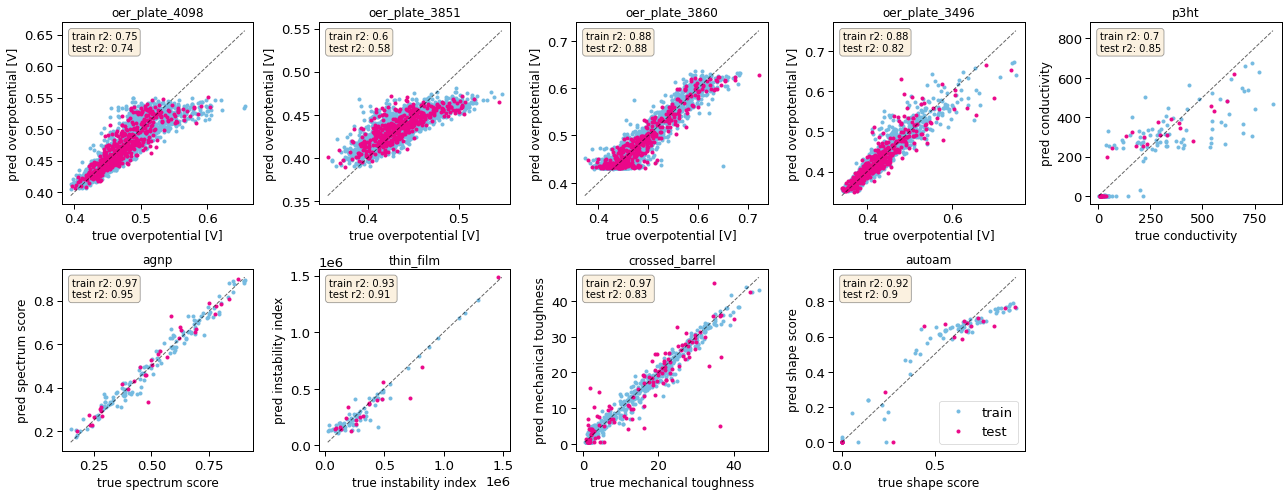

In [25]:
# make plots for single objective datasets

fig, axes = plt.subplots(2, 5, figsize=(18, 7))
axes = axes.flatten()

for ix, dataset_name in enumerate(dataset_names):
    if 'suzuki_' not in dataset_name:
        
        em = Emulator(dataset=dataset_name, model='BayesNeuralNet')
#         test_indices = res[dataset_name]['all_test_indices'][dataset_best_ixs[dataset_name]]
#         d.create_train_validate_test_splits(test_indices=test_indices)
    
        train_params = em.dataset.train_set_features.to_numpy()
        train_values = em.dataset.train_set_targets.to_numpy()
        test_params  = em.dataset.test_set_features.to_numpy()
        test_values  = em.dataset.test_set_targets.to_numpy()

        train_preds = em.run(train_params, num_samples=50)
        test_preds  = em.run(test_params, num_samples=50)
        
        
        train_r2 = round(r2_score(train_values, train_preds), 2)
        test_r2  = round(r2_score(test_values, test_preds), 2)
        
        # training data 
        axes[ix].plot(
            train_values.ravel(),
            train_preds.ravel(),
            c="#75BBE1",
            ls='',
            marker='o',
            markersize=3,
            label='train',
        )
        
        # training data 
        axes[ix].plot(
            test_values.ravel(),
            test_preds.ravel(),
            c="#EB0789",
            ls='',
            marker='o',
            markersize=3,
            label='test',
        )  
        
        max_ = np.amax(np.concatenate(
            (train_preds.ravel(), train_values.ravel(), test_preds.ravel(), test_values.ravel())
        ))
        min_ = np.amin(np.concatenate(
            (train_preds.ravel(), train_values.ravel(), test_preds.ravel(), test_values.ravel())
        ))
        axes[ix].plot([min_, max_], [min_, max_], ls='--', c='k', lw=1, alpha=0.6)
        
        axes[ix].set_xlabel(f'true {dataset_targets[dataset_name]}', fontsize=12)
        axes[ix].set_ylabel(f'pred {dataset_targets[dataset_name]}', fontsize=12)
        axes[ix].set_title(dataset_name, fontsize=14)
        
        str_ = f'train r2: {train_r2}\ntest r2: {test_r2}'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.4)
        axes[ix].text(
            0.05, 
            0.95, 
            str_, 
            transform=axes[ix].transAxes, 
            fontsize=10,
            verticalalignment='top', 
            bbox=props,
        )
        
        
    else:
        pass

axes[-2].legend(loc='lower right')
axes[-1].axis('off')
        
plt.tight_layout()
plt.savefig('emualtors_single_obj_pairity.png', dpi=400)

In [ ]:
# make plots for multiple objective datasets

fig, axes = plt.subplots(2, 4, figsize=(15, 7))

for ix, dataset_name in enumerate(dataset_names):
    if 'suzuki_' in dataset_name:
        
        em = Emulator(dataset=dataset_name, model='BayesNeuralNet')
#         test_indices = res[dataset_name]['all_test_indices'][dataset_best_ixs[dataset_name]]
#         d.create_train_validate_test_splits(test_indices=test_indices)
    
        train_params = em.dataset.train_set_features.to_numpy()
        train_values = em.dataset.train_set_targets.to_numpy()
        test_params  = em.dataset.test_set_features.to_numpy()
        test_values  = em.dataset.test_set_targets.to_numpy()

        train_preds = em.run(train_params, num_samples=50)
        test_preds  = em.run(test_params, num_samples=50)
        
        
        train_r2_yield = round(r2_score(train_values[:,0], train_preds[:,0]), 2)
        train_r2_ton = round(r2_score(train_values[:,1], train_preds[:,1]), 2)
        test_r2_yield = round(r2_score(test_values[:,0], test_preds[:,0]), 2)
        test_r2_ton = round(r2_score(test_values[:,1], test_preds[:,1]), 2)
        
        # training data yield
        axes[ix].plot(
            train_values.ravel(),
            train_preds.ravel(),
            c="#75BBE1",
            ls='',
            marker='o',
            markersize=3,
            label='train',
        )
        
        # training data 
        axes[ix].plot(
            test_values.ravel(),
            test_preds.ravel(),
            c="#EB0789",
            ls='',
            marker='o',
            markersize=3,
            label='test',
        )  
        
        max_ = np.amax(np.concatenate(
            (train_preds.ravel(), train_values.ravel(), test_preds.ravel(), test_values.ravel())
        ))
        min_ = np.amin(np.concatenate(
            (train_preds.ravel(), train_values.ravel(), test_preds.ravel(), test_values.ravel())
        ))
        axes[ix].plot([min_, max_], [min_, max_], ls='--', c='k', lw=1, alpha=0.6)
        
        axes[ix].set_xlabel(f'true {dataset_targets[dataset_name]}', fontsize=12)
        axes[ix].set_ylabel(f'pred {dataset_targets[dataset_name]}', fontsize=12)
        axes[ix].set_title(dataset_name, fontsize=14)
        
        str_ = f'train r2: {train_r2}\ntest r2: {test_r2}'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.4)
        axes[ix].text(
            0.05, 
            0.95, 
            str_, 
            transform=axes[ix].transAxes, 
            fontsize=10,
            verticalalignment='top', 
            bbox=props,
        )
        
        
    else:
        pass

axes[-2].legend(loc='lower right')
axes[-1].axis('off')
        
plt.tight_layout()

## Categorical emulators

In [3]:
res = pickle.load(open('emulators_categorical/best_scores.pkl', 'rb'))

In [8]:
dataset_names = [
    'perovskites', 'redoxmers', 'dye_lasers', 'suzuki_edbo', 'buchwald_a',
    'buchwald_b', 'buchwald_c', 'buchwald_d', 'buchwald_e',
]

dataset_params = {
        'perovskites': {'out_act': 'relu', 'feature_transform': 'identity', 'target_transform': 'mean'},
        'redoxmers': {'out_act': 'relu', 'feature_transform': 'identity', 'target_transform': 'normalize'},
        'dye_lasers': {'out_act': 'relu', 'feature_transform': 'identity', 'target_transform': 'normalize'},
        'suzuki_edbo': {'out_act': 'relu', 'feature_transform': 'identity', 'target_transform': 'mean'},
        'buchwald_a': {'out_act': 'relu', 'feature_transform': 'identity', 'target_transform': 'mean'},
        'buchwald_b': {'out_act': 'relu', 'feature_transform': 'identity', 'target_transform': 'mean'},
        'buchwald_c': {'out_act': 'relu', 'feature_transform': 'identity', 'target_transform': 'mean'},
        'buchwald_d': {'out_act': 'relu', 'feature_transform': 'identity', 'target_transform': 'mean'},
        'buchwald_e': {'out_act': 'relu', 'feature_transform': 'identity', 'target_transform': 'mean'},

}

dataset_best_ixs = {
    'perovskites': 14,  # 
    'redoxmers': 16,   # 
    'dye_lasers': 15,  # 
    'suzuki_edbo': 3,  # 
    'buchwald_a': 7,            #
    'buchwald_b': 0,            # 
    'buchwald_c': 15,       # 
    'buchwald_d': 14,  #
    'buchwald_e': 3,  #
}

In [9]:
def get_best_scores(res, dataset):
    scores = res[dataset]['scores']
    test_r2 = []
    sum_r2 = []
    for ix, score in enumerate(scores):
        test_r2.append(score['test_r2'])
        sum_r2.append(score['test_r2']+score['train_r2'])
    best_ix_test = np.argmax(test_r2)
    best_scores_test = scores[best_ix_test]
    best_ix_sum = np.argmax(sum_r2)
    best_scores_sum = scores[best_ix_sum]
    return best_ix_test, best_scores_test, best_ix_sum, best_scores_sum


def get_hyperparams(res, dataset_name, best_ix):
    return res[dataset_name]['params'][best_ix]

In [10]:
# for dataset in dataset_names:
#     print('DATASET : ', dataset)
#     best_ix_test, best_scores_test, best_ix_sum, best_scores_sum = get_best_scores(res, dataset)
#     print('best_ix_test : ', best_ix_test)
#     print('best_scores_test : ', best_scores_test)
#     print('best_ix_sum : ', best_ix_sum)
#     print('best_scores_sum : ', best_scores_sum)
#     print('\n\n')


In [17]:
_olympus_reference_colors = [
    "#08294C",
    "#75BBE1",
    "#D4E9F4",
    "#F2F2F2",
    "#F7A4D4",
    "#F75BB6",
    "#EB0789",
]

dataset_targets = {
    'oer_plate_4098': 'overpotential [V]',  
    'oer_plate_3851': 'overpotential [V]',  
    'oer_plate_3860': 'overpotential [V]',  
    'oer_plate_3496': 'overpotential [V]',  
    'p3ht': 'conductivity',           
    'agnp': 'spectrum score',           
    'thin_film': 'instability index',       
    'crossed_barrel': 'mechanical toughness',  
    'autoam': 'shape score',           
    'suzuki_i': ['yield [%]', '[prod/cat]'],        
    'suzuki_ii': ['yield [%]', '[prod/cat]'],       
    'suzuki_iii': ['yield [%]', '[prod/cat]'],       
    'suzuki_iv': ['yield [%]', '[prod/cat]'],       
}

### redoxmers

In [39]:
dataset_name = 'redoxmers'

em = load_emulator(f'emulators_categorical/emulator_{dataset_name}_BayesNeuralNet')
dataset = Dataset(kind=dataset_name)

train_params = dataset.train_set_features.to_numpy()
train_values = dataset.train_set_targets.to_numpy()
test_params  = dataset.test_set_features.to_numpy()
test_values  = dataset.test_set_targets.to_numpy()

train_preds, train_std_ep, train_std_al = em.run(train_params, num_samples=50)
test_preds, test_std_ep, test_std_al  = em.run(test_params, num_samples=50)


print(train_values.shape)
print(train_preds.shape)

train_r2_0 = round(r2_score(train_values[:,0], train_preds[:,0]), 2)
test_r2_0 = round(r2_score(test_values[:,0], test_preds[:,0]), 2)

train_r2_1 = round(r2_score(train_values[:,1], train_preds[:,1]), 2)
test_r2_1 = round(r2_score(test_values[:,1], test_preds[:,1]), 2)

train_r2_2 = round(r2_score(train_values[:,2], train_preds[:,2]), 2)
test_r2_2 = round(r2_score(test_values[:,2], test_preds[:,2]), 2)


(1126, 3)
(1126, 3)


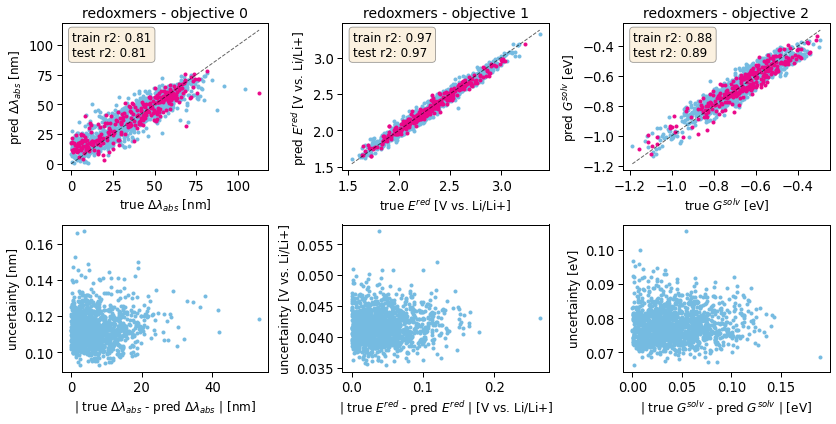

In [53]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

#-----------------
# ABS DIFF LAMBDA
#-----------------

# training data yield
axes[0,0].plot(
    train_values[:,0].ravel(),
    train_preds[:,0].ravel(),
    c="#75BBE1",
    ls='',
    marker='o',
    markersize=3,
    label='train',
)

# training data 
axes[0,0].plot(
    test_values[:,0].ravel(),
    test_preds[:,0].ravel(),
    c="#EB0789",
    ls='',
    marker='o',
    markersize=3,
    label='test',
)  
max_ = np.amax(np.concatenate(
    (train_preds[:,0].ravel(), train_values[:,0].ravel(), test_preds[:,0].ravel(), test_values[:,0].ravel())
))
min_ = np.amin(np.concatenate(
    (train_preds[:,0].ravel(), train_values[:,0].ravel(), test_preds[:,0].ravel(), test_values[:,0].ravel())
))
axes[0,0].plot([min_, max_], [min_, max_], ls='--', c='k', lw=1, alpha=0.6)


all_preds = np.concatenate((train_preds[:,0], test_preds[:,0]))
all_values = np.concatenate((train_values[:,0], test_values[:,0]))
all_sigma_ep = np.concatenate((train_std_ep[:,0], test_std_ep[:,0]))
all_sigma_al = np.concatenate((train_std_al[:,0], test_std_al[:,0]))

axes[1,0].plot(
    np.abs(all_preds.ravel()-all_values.ravel()),
    all_sigma_ep.ravel()+all_sigma_al.ravel(),
    c="#75BBE1",
    ls='',
    marker='o',
    markersize=3,
)


axes[0,0].set_xlabel(r'true $\Delta \lambda_{abs}$ [nm]', fontsize=12)
axes[0,0].set_ylabel(r'pred $\Delta \lambda_{abs}$ [nm]', fontsize=12)
axes[0,0].set_title(dataset_name+' - objective 0', fontsize=14)

axes[1,0].set_xlabel(r'| true $\Delta \lambda_{abs}$ - pred $\Delta \lambda_{abs}$ | [nm]', fontsize=12)
axes[1,0].set_ylabel(r'uncertainty [nm]', fontsize=12)

str_ = f'train r2: {train_r2_0}\ntest r2: {test_r2_0}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.4)
axes[0,0].text(
    0.05, 
    0.95, 
    str_, 
    transform=axes[0,0].transAxes, 
    fontsize=12,
    verticalalignment='top', 
    bbox=props,
)


#--------------------
# REDUCTION POTENTIAL
#--------------------

# training data yield
axes[0,1].plot(
    train_values[:,1].ravel(),
    train_preds[:,1].ravel(),
    c="#75BBE1",
    ls='',
    marker='o',
    markersize=3,
    label='train',
)

# training data 
axes[0,1].plot(
    test_values[:,1].ravel(),
    test_preds[:,1].ravel(),
    c="#EB0789",
    ls='',
    marker='o',
    markersize=3,
    label='test',
)  
max_ = np.amax(np.concatenate(
    (train_preds[:,1].ravel(), train_values[:,1].ravel(), test_preds[:,1].ravel(), test_values[:,1].ravel())
))
min_ = np.amin(np.concatenate(
    (train_preds[:,1].ravel(), train_values[:,1].ravel(), test_preds[:,1].ravel(), test_values[:,1].ravel())
))
axes[0,1].plot([min_, max_], [min_, max_], ls='--', c='k', lw=1, alpha=0.6)


all_preds = np.concatenate((train_preds[:,1], test_preds[:,1]))
all_values = np.concatenate((train_values[:,1], test_values[:,1]))
all_sigma_ep = np.concatenate((train_std_ep[:,1], test_std_ep[:,1]))
all_sigma_al = np.concatenate((train_std_al[:,1], test_std_al[:,1]))

axes[1,1].plot(
    np.abs(all_preds.ravel()-all_values.ravel()),
    all_sigma_ep.ravel()+all_sigma_al.ravel(),
    c="#75BBE1",
    ls='',
    marker='o',
    markersize=3,
)

axes[0,1].set_xlabel(r'true $E^{red}$ [V vs. Li/Li+]', fontsize=12)
axes[0,1].set_ylabel(r'pred $E^{red}$ [V vs. Li/Li+]', fontsize=12)
axes[0,1].set_title(dataset_name+' - objective 1', fontsize=14)

axes[1,1].set_xlabel(r'| true $E^{red}$ - pred $E^{red}$ | [V vs. Li/Li+]', fontsize=12)
axes[1,1].set_ylabel(r'uncertainty [V vs. Li/Li+]', fontsize=12)

str_ = f'train r2: {train_r2_1}\ntest r2: {test_r2_1}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.4)
axes[0,1].text(
    0.05, 
    0.95, 
    str_, 
    transform=axes[0,1].transAxes, 
    fontsize=12,
    verticalalignment='top', 
    bbox=props,
)


#----------------------
# SOLVATION FREE ENERGY
#----------------------

# training data yield
axes[0,2].plot(
    train_values[:,2].ravel(),
    train_preds[:,2].ravel(),
    c="#75BBE1",
    ls='',
    marker='o',
    markersize=3,
    label='train',
)

# training data 
axes[0,2].plot(
    test_values[:,2].ravel(),
    test_preds[:,2].ravel(),
    c="#EB0789",
    ls='',
    marker='o',
    markersize=3,
    label='test',
)  
max_ = np.amax(np.concatenate(
    (train_preds[:,2].ravel(), train_values[:,2].ravel(), test_preds[:,2].ravel(), test_values[:,2].ravel())
))
min_ = np.amin(np.concatenate(
    (train_preds[:,2].ravel(), train_values[:,2].ravel(), test_preds[:,2].ravel(), test_values[:,2].ravel())
))
axes[0,2].plot([min_, max_], [min_, max_], ls='--', c='k', lw=1, alpha=0.6)


all_preds = np.concatenate((train_preds[:,2], test_preds[:,2]))
all_values = np.concatenate((train_values[:,2], test_values[:,2]))
all_sigma_ep = np.concatenate((train_std_ep[:,2], test_std_ep[:,2]))
all_sigma_al = np.concatenate((train_std_al[:,2], test_std_al[:,2]))

axes[1,2].plot(
    np.abs(all_preds.ravel()-all_values.ravel()),
    all_sigma_ep.ravel()+all_sigma_al.ravel(),
    c="#75BBE1",
    ls='',
    marker='o',
    markersize=3,
)

axes[0,2].set_xlabel(r'true $G^{solv}$ [eV]', fontsize=12)
axes[0,2].set_ylabel(r'pred $G^{solv}$ [eV]', fontsize=12)
axes[0,2].set_title(dataset_name+' - objective 2', fontsize=14)


axes[1,2].set_xlabel(r'| true $G^{solv}$ - pred $G^{solv}$ | [eV]', fontsize=12)
axes[1,2].set_ylabel(r'uncertainty [eV]', fontsize=12)


str_ = f'train r2: {train_r2_2}\ntest r2: {test_r2_2}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.4)
axes[0,2].text(
    0.05, 
    0.95, 
    str_, 
    transform=axes[0,2].transAxes, 
    fontsize=12,
    verticalalignment='top', 
    bbox=props,
)


plt.tight_layout()


### dye_lasers

In [54]:
dataset_name = 'dye_lasers'

em = load_emulator(f'emulators_categorical/emulator_{dataset_name}_BayesNeuralNet')
dataset = Dataset(kind=dataset_name)

train_params = dataset.train_set_features.to_numpy()
train_values = dataset.train_set_targets.to_numpy()
test_params  = dataset.test_set_features.to_numpy()
test_values  = dataset.test_set_targets.to_numpy()

train_preds, train_std_ep, train_std_al = em.run(train_params, num_samples=50)
test_preds, test_std_ep, test_std_al  = em.run(test_params, num_samples=50)


print(train_values.shape)
print(train_preds.shape)

train_r2_0 = round(r2_score(train_values[:,0], train_preds[:,0]), 2)
test_r2_0 = round(r2_score(test_values[:,0], test_preds[:,0]), 2)

train_r2_1 = round(r2_score(train_values[:,1], train_preds[:,1]), 2)
test_r2_1 = round(r2_score(test_values[:,1], test_preds[:,1]), 2)

train_r2_2 = round(r2_score(train_values[:,2], train_preds[:,2]), 2)
test_r2_2 = round(r2_score(test_values[:,2], test_preds[:,2]), 2)


/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)
/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)


(2766, 3)
(2766, 3)


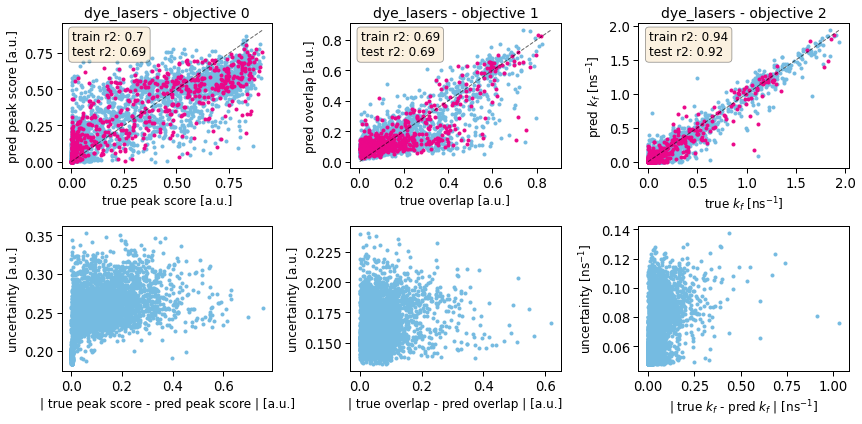

In [56]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

#-----------------
# PEAK SCORE
#-----------------

# training data yield
axes[0,0].plot(
    train_values[:,0].ravel(),
    train_preds[:,0].ravel(),
    c="#75BBE1",
    ls='',
    marker='o',
    markersize=3,
    label='train',
)

# training data 
axes[0,0].plot(
    test_values[:,0].ravel(),
    test_preds[:,0].ravel(),
    c="#EB0789",
    ls='',
    marker='o',
    markersize=3,
    label='test',
)  
max_ = np.amax(np.concatenate(
    (train_preds[:,0].ravel(), train_values[:,0].ravel(), test_preds[:,0].ravel(), test_values[:,0].ravel())
))
min_ = np.amin(np.concatenate(
    (train_preds[:,0].ravel(), train_values[:,0].ravel(), test_preds[:,0].ravel(), test_values[:,0].ravel())
))
axes[0,0].plot([min_, max_], [min_, max_], ls='--', c='k', lw=1, alpha=0.6)


all_preds = np.concatenate((train_preds[:,0], test_preds[:,0]))
all_values = np.concatenate((train_values[:,0], test_values[:,0]))
all_sigma_ep = np.concatenate((train_std_ep[:,0], test_std_ep[:,0]))
all_sigma_al = np.concatenate((train_std_al[:,0], test_std_al[:,0]))

axes[1,0].plot(
    np.abs(all_preds.ravel()-all_values.ravel()),
    all_sigma_ep.ravel()+all_sigma_al.ravel(),
    c="#75BBE1",
    ls='',
    marker='o',
    markersize=3,
)


axes[0,0].set_xlabel(r'true peak score [a.u.]', fontsize=12)
axes[0,0].set_ylabel(r'pred peak score [a.u.]', fontsize=12)
axes[0,0].set_title(dataset_name+' - objective 0', fontsize=14)

axes[1,0].set_xlabel(r'| true peak score - pred peak score | [a.u.]', fontsize=12)
axes[1,0].set_ylabel(r'uncertainty [a.u.]', fontsize=12)

str_ = f'train r2: {train_r2_0}\ntest r2: {test_r2_0}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.4)
axes[0,0].text(
    0.05, 
    0.95, 
    str_, 
    transform=axes[0,0].transAxes, 
    fontsize=12,
    verticalalignment='top', 
    bbox=props,
)


#--------------------
# SPECTRAL OVERLAP
#--------------------

# training data yield
axes[0,1].plot(
    train_values[:,1].ravel(),
    train_preds[:,1].ravel(),
    c="#75BBE1",
    ls='',
    marker='o',
    markersize=3,
    label='train',
)

# training data 
axes[0,1].plot(
    test_values[:,1].ravel(),
    test_preds[:,1].ravel(),
    c="#EB0789",
    ls='',
    marker='o',
    markersize=3,
    label='test',
)  
max_ = np.amax(np.concatenate(
    (train_preds[:,1].ravel(), train_values[:,1].ravel(), test_preds[:,1].ravel(), test_values[:,1].ravel())
))
min_ = np.amin(np.concatenate(
    (train_preds[:,1].ravel(), train_values[:,1].ravel(), test_preds[:,1].ravel(), test_values[:,1].ravel())
))
axes[0,1].plot([min_, max_], [min_, max_], ls='--', c='k', lw=1, alpha=0.6)


all_preds = np.concatenate((train_preds[:,1], test_preds[:,1]))
all_values = np.concatenate((train_values[:,1], test_values[:,1]))
all_sigma_ep = np.concatenate((train_std_ep[:,1], test_std_ep[:,1]))
all_sigma_al = np.concatenate((train_std_al[:,1], test_std_al[:,1]))

axes[1,1].plot(
    np.abs(all_preds.ravel()-all_values.ravel()),
    all_sigma_ep.ravel()+all_sigma_al.ravel(),
    c="#75BBE1",
    ls='',
    marker='o',
    markersize=3,
)

axes[0,1].set_xlabel(r'true overlap [a.u.]', fontsize=12)
axes[0,1].set_ylabel(r'pred overlap [a.u.]', fontsize=12)
axes[0,1].set_title(dataset_name+' - objective 1', fontsize=14)

axes[1,1].set_xlabel(r'| true overlap - pred overlap | [a.u.]', fontsize=12)
axes[1,1].set_ylabel(r'uncertainty [a.u.]', fontsize=12)

str_ = f'train r2: {train_r2_1}\ntest r2: {test_r2_1}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.4)
axes[0,1].text(
    0.05, 
    0.95, 
    str_, 
    transform=axes[0,1].transAxes, 
    fontsize=12,
    verticalalignment='top', 
    bbox=props,
)


#----------------------
# FLUORESCENCE RATE
#----------------------

# training data yield
axes[0,2].plot(
    train_values[:,2].ravel(),
    train_preds[:,2].ravel(),
    c="#75BBE1",
    ls='',
    marker='o',
    markersize=3,
    label='train',
)

# training data 
axes[0,2].plot(
    test_values[:,2].ravel(),
    test_preds[:,2].ravel(),
    c="#EB0789",
    ls='',
    marker='o',
    markersize=3,
    label='test',
)  
max_ = np.amax(np.concatenate(
    (train_preds[:,2].ravel(), train_values[:,2].ravel(), test_preds[:,2].ravel(), test_values[:,2].ravel())
))
min_ = np.amin(np.concatenate(
    (train_preds[:,2].ravel(), train_values[:,2].ravel(), test_preds[:,2].ravel(), test_values[:,2].ravel())
))
axes[0,2].plot([min_, max_], [min_, max_], ls='--', c='k', lw=1, alpha=0.6)


all_preds = np.concatenate((train_preds[:,2], test_preds[:,2]))
all_values = np.concatenate((train_values[:,2], test_values[:,2]))
all_sigma_ep = np.concatenate((train_std_ep[:,2], test_std_ep[:,2]))
all_sigma_al = np.concatenate((train_std_al[:,2], test_std_al[:,2]))

axes[1,2].plot(
    np.abs(all_preds.ravel()-all_values.ravel()),
    all_sigma_ep.ravel()+all_sigma_al.ravel(),
    c="#75BBE1",
    ls='',
    marker='o',
    markersize=3,
)

axes[0,2].set_xlabel(r'true $k_f$ [ns$^{-1}$]', fontsize=12)
axes[0,2].set_ylabel(r'pred $k_f$ [ns$^{-1}$]', fontsize=12)
axes[0,2].set_title(dataset_name+' - objective 2', fontsize=14)


axes[1,2].set_xlabel(r'| true $k_f$ - pred $k_f$ | [ns$^{-1}$]', fontsize=12)
axes[1,2].set_ylabel(r'uncertainty [ns$^{-1}$]', fontsize=12)


str_ = f'train r2: {train_r2_2}\ntest r2: {test_r2_2}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.4)
axes[0,2].text(
    0.05, 
    0.95, 
    str_, 
    transform=axes[0,2].transAxes, 
    fontsize=12,
    verticalalignment='top', 
    bbox=props,
)


plt.tight_layout()

### Remainder of fully categorical datasets

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)
/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)
/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)
/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.

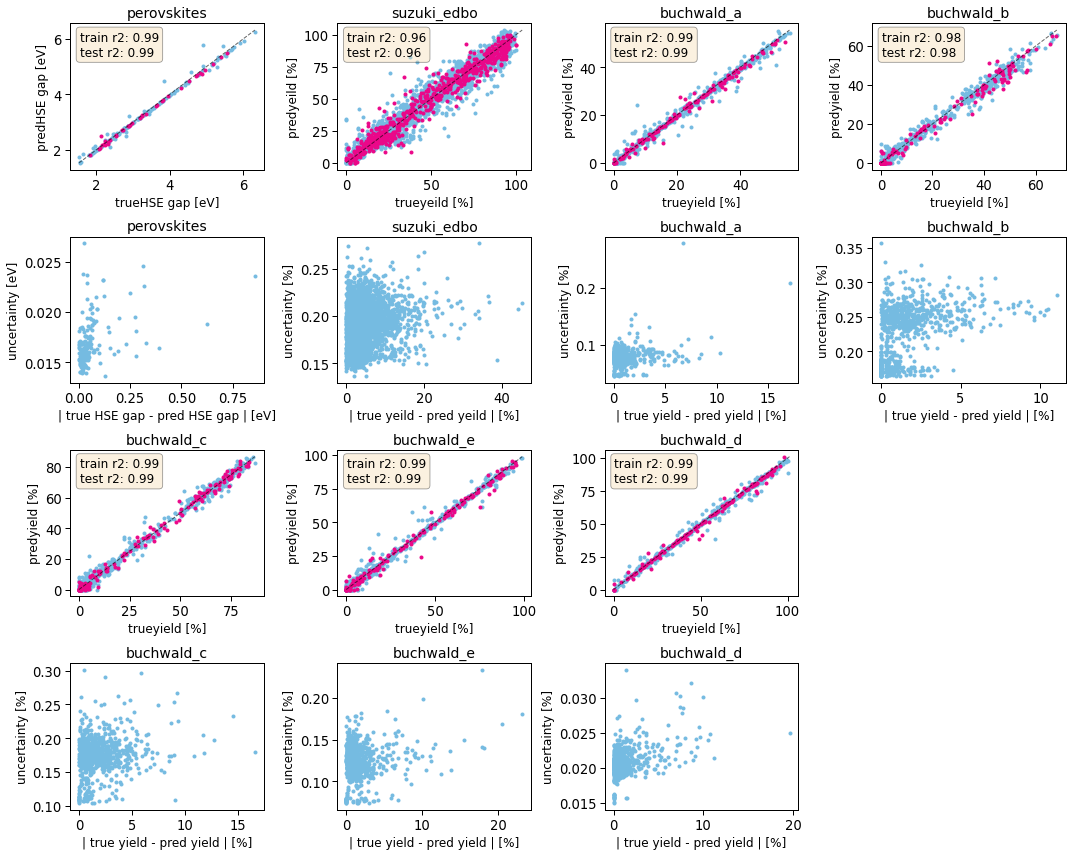

In [74]:
fig, axes = plt.subplots(4, 4, figsize=(15, 12))

dataset_names = ['perovskites', 'suzuki_edbo', 'buchwald_a', 'buchwald_b',
                 'buchwald_c', 'buchwald_e', 'buchwald_d']

dataset_targets = {
    'perovskites': 'HSE gap',  
    'suzuki_edbo': 'yeild',  
    'buchwald_a': 'yield',  
    'buchwald_b': 'yield',  
    'buchwald_c': 'yield',          
    'buchwald_d': 'yield',          
    'buchwald_e': 'yield',       
}
dataset_units = {
    'perovskites': '[eV]',  
    'suzuki_edbo': '[%]',  
    'buchwald_a': '[%]',  
    'buchwald_b': '[%]',  
    'buchwald_c': '[%]',          
    'buchwald_d': '[%]',          
    'buchwald_e': '[%]',   
}


for ix, dataset_name in enumerate(dataset_names):
    
    if ix <4:
        col_key=ix
        row_key=0
    elif ix==4:
        col_key=0
        row_key=2
    elif ix==5:
        col_key=1
        row_key=2
    elif ix==6:
        col_key=2
        row_key=2
        

    em = load_emulator(f'emulators_categorical/emulator_{dataset_name}_BayesNeuralNet')
    dataset = Dataset(kind=dataset_name)

    train_params = dataset.train_set_features.to_numpy()
    train_values = dataset.train_set_targets.to_numpy()
    test_params  = dataset.test_set_features.to_numpy()
    test_values  = dataset.test_set_targets.to_numpy()

    train_preds, train_std_ep, train_std_al = em.run(train_params, num_samples=50)
    test_preds, test_std_ep, test_std_al  = em.run(test_params, num_samples=50)

    train_r2_0 = round(r2_score(train_values[:,0], train_preds[:,0]), 2)
    test_r2_0 = round(r2_score(test_values[:,0], test_preds[:,0]), 2)
    
    # training data yield
    axes[row_key,col_key].plot(
        train_values[:,0].ravel(),
        train_preds[:,0].ravel(),
        c="#75BBE1",
        ls='',
        marker='o',
        markersize=3,
        label='train',
    )

    # training data 
    axes[row_key,col_key].plot(
        test_values[:,0].ravel(),
        test_preds[:,0].ravel(),
        c="#EB0789",
        ls='',
        marker='o',
        markersize=3,
        label='test',
    )  
    max_ = np.amax(np.concatenate(
        (train_preds[:,0].ravel(), train_values[:,0].ravel(), test_preds[:,0].ravel(), test_values[:,0].ravel())
    ))
    min_ = np.amin(np.concatenate(
        (train_preds[:,0].ravel(), train_values[:,0].ravel(), test_preds[:,0].ravel(), test_values[:,0].ravel())
    ))
    axes[row_key,col_key].plot([min_, max_], [min_, max_], ls='--', c='k', lw=1, alpha=0.6)


    all_preds = np.concatenate((train_preds[:,0], test_preds[:,0]))
    all_values = np.concatenate((train_values[:,0], test_values[:,0]))
    all_sigma_ep = np.concatenate((train_std_ep[:,0], test_std_ep[:,0]))
    all_sigma_al = np.concatenate((train_std_al[:,0], test_std_al[:,0]))

    axes[row_key+1,col_key].plot(
        np.abs(all_preds.ravel()-all_values.ravel()),
        all_sigma_ep.ravel()+all_sigma_al.ravel(),
        c="#75BBE1",
        ls='',
        marker='o',
        markersize=3,
    )
#     axes[row_key+1,col_key].hexbin(
#         x=np.abs(all_preds.ravel()-all_values.ravel()),
#         y=all_sigma_ep.ravel()+all_sigma_al.ravel(),
#         #c="#75BBE1",
#         #ls='',
#         #marker='o',
#         #markersize=3,
#         gridsize=50,
#         bins=None,
#         cmap='Blues',
#     )



    axes[row_key,col_key].set_xlabel(r'true'+dataset_targets[dataset_name]+' '+dataset_units[dataset_name], fontsize=12)
    axes[row_key,col_key].set_ylabel(r'pred'+dataset_targets[dataset_name]+' '+dataset_units[dataset_name], fontsize=12)
    axes[row_key,col_key].set_title(dataset_name, fontsize=14)

    axes[row_key+1,col_key].set_xlabel(f'| true {dataset_targets[dataset_name]} - pred {dataset_targets[dataset_name]} | {dataset_units[dataset_name]}', fontsize=12)
    axes[row_key+1,col_key].set_ylabel(f'uncertainty {dataset_units[dataset_name]}', fontsize=12)
    axes[row_key+1,col_key].set_title(dataset_name, fontsize=14)
    
    str_ = f'train r2: {train_r2_0}\ntest r2: {test_r2_0}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.4)
    axes[row_key,col_key].text(
        0.05, 
        0.95, 
        str_, 
        transform=axes[row_key,col_key].transAxes, 
        fontsize=12,
        verticalalignment='top', 
        bbox=props,
    )


axes[-1,-1].set_visible(False) 
axes[-2,-1].set_visible(False) 

plt.tight_layout()

    

In [35]:
dataset_name = 'buchwald_c'

em = load_emulator(f'emulators_categorical/emulator_{dataset_name}_BayesNeuralNet')
dataset = Dataset(kind=dataset_name)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)
/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)


In [36]:
train_params = dataset.train_set_features.to_numpy()
train_values = dataset.train_set_targets.to_numpy()
test_params  = dataset.test_set_features.to_numpy()
test_values  = dataset.test_set_targets.to_numpy()

train_preds, train_std_ep, train_std_al = em.run(train_params, num_samples=50)
test_preds, test_std_ep, test_std_al  = em.run(test_params, num_samples=50)


print(train_values.shape)
print(train_preds.shape)

train_r2_yield = round(r2_score(train_values, train_preds), 2)
test_r2_yield = round(r2_score(test_values, test_preds), 2)




(634, 1)
(634, 1)


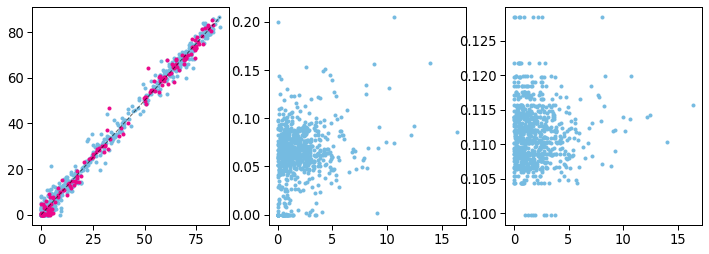

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ix=0

# training data yield
axes[0].plot(
    train_values.ravel(),
    train_preds.ravel(),
    c="#75BBE1",
    ls='',
    marker='o',
    markersize=3,
    label='train',
)

# training data 
axes[0].plot(
    test_values.ravel(),
    test_preds.ravel(),
    c="#EB0789",
    ls='',
    marker='o',
    markersize=3,
    label='test',
)  

all_preds = np.concatenate((train_preds, test_preds))
all_values = np.concatenate((train_values, test_values))
all_sigma_ep = np.concatenate((train_std_ep, test_std_ep))
all_sigma_al = np.concatenate((train_std_al, test_std_al))

axes[1].plot(
    np.abs(all_preds.ravel()-all_values.ravel()),
    all_sigma_ep.ravel(),
    c="#75BBE1",
    ls='',
    marker='o',
    markersize=3,
    label='train',
)

axes[2].plot(
    np.abs(all_preds.ravel()-all_values.ravel()),
    all_sigma_al.ravel(),
    c="#75BBE1",
    ls='',
    marker='o',
    markersize=3,
    label='train',
)


max_ = np.amax(np.concatenate(
    (train_preds.ravel(), train_values.ravel(), test_preds.ravel(), test_values.ravel())
))
min_ = np.amin(np.concatenate(
    (train_preds.ravel(), train_values.ravel(), test_preds.ravel(), test_values.ravel())
))
axes[0].plot([min_, max_], [min_, max_], ls='--', c='k', lw=1, alpha=0.6)



